# Getting Started with AleaTHOR

In this notebook you will learn how to:
- Define surfaces and build CSG cells from scratch
- Inspect model contents (cells, materials, bounds)
- Run point-in-cell queries
- Plot 2-D slices of the geometry
- Export to MCNP format

In [1]:
%matplotlib inline
import aleathor as ath
print(f"AleaTHOR version: {ath.__version__}")

AleaTHOR version: 0.1.0


## Define surfaces

We model a simplified PWR fuel pin: fuel pellet, helium gap, Zircaloy cladding, and water moderator.

In [2]:
# Fuel pellet — sphere of radius 0.41 cm
fuel_surf = ath.Sphere(0, 0, 0, radius=0.41)

# Gap — cylinder along Z, radius 0.42 cm
gap_surf = ath.CylinderZ(0, 0, radius=0.42)

# Cladding outer — cylinder along Z, radius 0.48 cm
clad_surf = ath.CylinderZ(0, 0, radius=0.48)

# Water box — half-pitch of 0.63 cm
water_box = ath.Box(-0.63, 0.63, -0.63, 0.63, -1, 1)

## Build cells with CSG operators

| Operator | Meaning |
|----------|---------|
| `-surface` | interior (negative halfspace) |
| `+surface` | exterior (positive halfspace) |
| `&` | intersection |
| `\|` | union |
| `region_a - region_b` | difference (`a & ~b`) |

In [3]:
model = ath.Model("PWR Pin Cell")

# Cell 1 — fuel (inside sphere)
model.add_cell(region=-fuel_surf,
               material=1, density=10.5, name="fuel")

# Cell 2 — helium gap (inside gap cylinder, outside fuel sphere)
model.add_cell(region=-gap_surf & +fuel_surf,
               material=2, density=0.0002, name="gap")

# Cell 3 — cladding (inside clad cylinder, outside gap cylinder)
model.add_cell(region=-clad_surf & +gap_surf,
               material=3, density=6.56, name="cladding")

# Cell 4 — moderator water (inside box, outside cladding)
model.add_cell(region=-water_box & +clad_surf,
               material=4, density=0.7, name="water")

_CellData(id=4, region=-Box(4) & +CylinderZ(3), material=4, density=0.7, density_unit='g/cm3', name='water', universe=0, fill=None, fill_transform=None, importance=1.0)

## Inspect the model

In [4]:
print(model)
print()

for cell in model.cells:
    print(f"Cell {cell.id:2d}  mat={cell.material}  "
          f"rho={cell.density:+.4f}  name={cell.name!r:12s}  "
          f"bounds={tuple(round(b,2) for b in cell.bounds)}")

Model: 4 cells, 4 surfaces, 0 universes

Cell  1  mat=1  rho=+10.5000  name='fuel'        bounds=(-0.41, 0.41, -0.41, 0.41, -0.41, 0.41)
Cell  2  mat=2  rho=+0.0002  name='gap'         bounds=(-0.42, 0.42, -0.42, 0.42, -10000000000.0, 10000000000.0)
Cell  3  mat=3  rho=+6.5600  name='cladding'    bounds=(-0.48, 0.48, -0.48, 0.48, -10000000000.0, 10000000000.0)
Cell  4  mat=4  rho=+0.7000  name='water'       bounds=(-0.63, 0.63, -0.63, 0.63, -1.0, 1.0)


## Point queries

Find which cell contains a given point.

In [5]:
# Single cell at a point
cell = model.cell_at(0, 0, 0)
print(f"cell_at(0, 0, 0) -> Cell {cell.id} ({cell.name})")

# All cells at a point (for hierarchical models with FILLs)
hits = model.cells_at(0, 0, 0)
print(f"cells_at(0, 0, 0) -> {[c.id for c in hits]}")

# Check if a specific cell contains a point
fuel_cell = model[1]
print(f"\nfuel_cell.contains(0.0, 0, 0) = {fuel_cell.contains(0.0, 0, 0)}")
print(f"fuel_cell.contains(0.5, 0, 0) = {fuel_cell.contains(0.5, 0, 0)}")

cell_at(0, 0, 0) -> Cell 1 (fuel)
cells_at(0, 0, 0) -> [1]

fuel_cell.contains(0.0, 0, 0) = True
fuel_cell.contains(0.5, 0, 0) = False


## Plot a slice

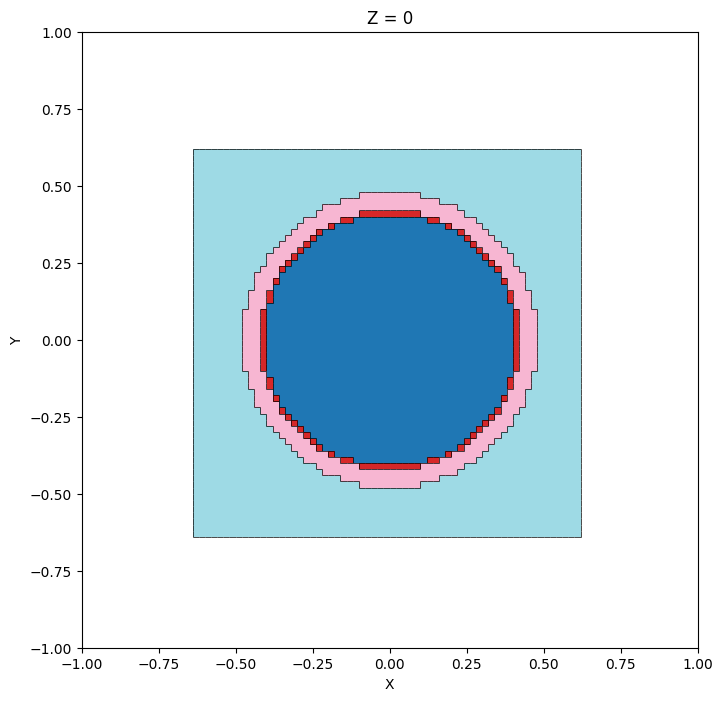

<Axes: title={'center': 'Z = 0'}, xlabel='X', ylabel='Y'>

In [6]:
# XY slice at z = 0 — colored by cell ID
model.plot(z=0, bounds=(-1, 1, -1, 1))

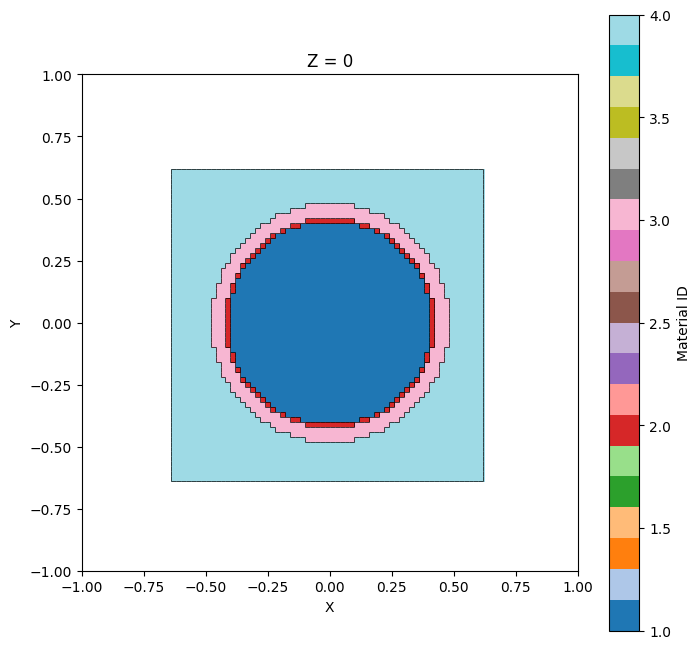

<Axes: title={'center': 'Z = 0'}, xlabel='X', ylabel='Y'>

In [7]:
# Same slice, colored by material with a colorbar
model.plot(z=0, bounds=(-1, 1, -1, 1), by_material=True, show_colorbar=True)

## Export to MCNP

In [ ]:
# Save as MCNP input file
model.save("/tmp/pin_cell.inp")

# Preview the MCNP input
print(model.to_mcnp_string())